In [23]:
import pandas as pd
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [24]:
data = pd.read_csv("covid_19_data.csv")
df = data.drop(["Province/State", "Country/Region", "Last Update"], axis =1)
data = df.groupby(['ObservationDate', "Confirmed", "Deaths", "Recovered"])
result = df.groupby(['ObservationDate']).agg({'Confirmed': sum,'Deaths': sum, "Recovered":sum, 'SNo': list}).reset_index()

In [25]:
result = result.sort_values(by='SNo')
result = result.drop(["SNo"], axis =1 )

In [26]:
result = df.groupby(['ObservationDate']).agg({'Confirmed': sum,'Deaths': sum, "Recovered":sum, 'SNo': list}).reset_index()
result = result.sort_values(by='SNo')
result = result.drop(["SNo"], axis =1 )
input_data = pd.DataFrame()

input_data["Confirmed"] = result['Confirmed'].cumsum()
input_data["Deaths"] = result['Deaths'].cumsum()
input_data["Recovered"] = result['Recovered'].cumsum()
input_data = input_data.reset_index()
input_data = input_data.drop(["index"], axis =1)
test_data = input_data
test_data = test_data.tail(60)
input_data = input_data

In [27]:
population = 788834676700
X_confirmed = np.array(input_data["Confirmed"])
recovered = np.array(input_data["Recovered"])
death = np.array(input_data["Deaths"])


X = X_confirmed - recovered - death
R = recovered + death
n = np.array([population] * len(X), dtype=np.float64)
S = n - X - R

In [28]:

gamma = (R[1:] - R[:-1]) / X[:-1] #rate at which people recover or die
beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1])) #Transmission rate
R0 = beta / gamma  #reproduction number

In [29]:

def dataset(data, orders):
    x_train = []
    for i in range(len(data)  - orders):
        x_train.append(data[i:orders + i])
    return np.array(x_train), data[orders:]

In [30]:
x_beta, y_beta = dataset(beta, 10)
x_gamma, y_gamma = dataset(gamma, 10)

In [31]:
import warnings
warnings.filterwarnings("ignore")

beta_ = Ridge(alpha=0.1, fit_intercept=False)
gamma_ = Ridge(alpha=0.1, fit_intercept=False)
beta_.fit(x_beta, y_beta)
gamma_.fit(x_gamma, y_gamma)

#Prediction
beta_pred = beta_.predict(x_beta)
gamma_pred = gamma_.predict(x_gamma)

In [32]:

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta = np.array(beta_pred[-10:]).tolist()
predict_gamma = np.array(gamma_pred[-10:]).tolist()

In [33]:

for i in range(20): #lags = 10
    next_beta = beta_.predict(np.asarray([predict_beta[-10:]]))[0]
    next_gamma = gamma_.predict(np.asarray([predict_gamma[-10:]]))[0]
    if next_beta<0:
        predict_beta.append(0)
    else:
        predict_beta.append(next_beta)
        
    if next_gamma<0:
        predict_gamma.append(0)
    else:
        predict_gamma.append(next_gamma)
        
    S_predict.append(((-predict_beta[-1] * S_predict[-1] * X_predict[-1]) / n[-1]) + S_predict[-1])
    X_predict.append(((predict_beta[-1] * S_predict[-1] * X_predict[-1]) / n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1])
    R_predict.append((predict_gamma[-1] * X_predict[-1]) + R_predict[-1])

In [34]:

def plot():
    plt.figure(1)
    plt.title('SIR Model')
    plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, 'o' ,label=" Predicted Positive Cases", color='green')
    plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, 'o', label="Predicted Recovered + Death", color='grey')
    plt.plot(range(400,len(X)), X[400:], 'o', label="Positive Cases", color='gold')
    plt.plot(range(400, len(X)), R[400:], 'o', label="Recovered + Death", color='brown')
    plt.xlabel('Time Line(in days)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

**************************************************
Covid-19 infected cases:  10226611791
Recovered + Deaths:  16177397931
Expected Confirmed cases:  26404009722
**************************************************


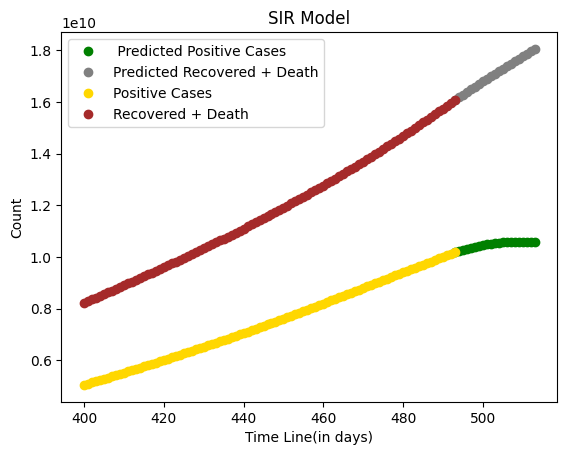

In [35]:

print("*"*50)
print("Covid-19 infected cases: ", int(X_predict[1]))
print("Recovered + Deaths: ", int(R_predict[1]))
print("Expected Confirmed cases: ",int(X_predict[1] + R_predict[1]))
print("*"*50)
plot()